University of Helsinki, Master's Programme in Data Science  
DATA20047 Probabilistic Cognitive Modelling - Spring 2023  
Luigi Acerbi  

# Problem Set 4: Combining inference with utility, and everything

- This homework problem set focuses on **Week 7** of the course, plus a recap of everything we have done in the course.
- This problem set is worth **30 points** in total (out of 100 for the full course).
- Check the submission deadline on Moodle! **Note that the deadline is at noon.**


## Submission instructions

Submission must be perfomed entirely on Moodle (**not** by email).
1. When you have completed the exercises, save the notebook.
2. Report your solutions and answers on Moodle ("*Problem set 4 answer return*").
3. Submit two files on Moodle ("*Problem set 4 notebook return*"): 
  - The notebook as `.ipynb`.
  - The same notebook downloaded as `.pdf` (there are various ways to save the file as PDF, the most general is "File" > "Print Preview" and then print the page to PDF using your browser - remember to enter the Print Preview first).

## IMPORTANT

1. Do not share your code and answers with others. Contrary to the class exercises, which you can do with others, these problems are *not* group work and must be done individually.
2. It is allowed to use snippets of code from the lecture exercises and model solutions.
3. It is your responsibility to ensure that the notebook has fully finished running all the cells, all the plots view properly etc. before submitting it. However, the notebook should be runnable from scratch if needed ("Kernel > Restart & Run All").
4. Submit your work by the deadline.
5. Unless stated otherwise, please report your numerical answers in Moodle with full numerical precision (~14-15 digits), unless the answer is an integer.
6. If you are confused, think there is a mistake or find things too difficult, please ask on Moodle.

## References

- \[**MKG22**\] Ma WJ, Körding K, and Goldreich D. "Bayesian Models of Perception and Action: An Introduction". MIT Press, 2022.
- \[**AWV12**\] Acerbi L, Wolpert DM, Vijayakumar S. "Internal Representations of Temporal Statistics and Feedback Calibrate Motor-Sensory Interval Timing". *PLoS Computational Biology*, 2012. [Link](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002771)

In [1]:
# set-up -- do not change
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
npr.seed(1)

# Question 4.1 (6 pts)

> In this question, we will look at the optimal aim location when playing a modified game of darts.

Assume you are playing a game of darts, that is you need to throw a dart at a target a couple of meters away from you. For simplicity, we assume this is a modified version of the game in which the target board comprises of a series of vertical bands, so that only the horizontal landing location of the dart matters. Landing the dart on each different sector is associated with a different score.

We measure horizontal location starting from the center of the dart board ($0$ cm), with negative numbers meaning a position to the left of the center and positive numbers a position to the right of the center. We ignore the vertical position, assuming the bands are tall enough to be easy to hit on the vertical axis.

The sectors are characterized by their bounds on the board (start and end location) and their score, as follows:

- -25 to -15 cm: 15 points.
- -15 to -5 cm: 10 points.
- -5 to 5 cm: 20 points.
- 5 to 15 cm: 5 points.
- 15 to 25 cm: 25 points.

If the dart lands outside the board, you would get 0 points.

Given the aim location $\hat{s}$, we assume that due to motor noise, the actual *hit* location $r$ (where the dart actually lands) is distributed as follows:
$$
p(r|\hat{s}) = (1-\lambda) \mathcal{N}\left(r; \hat{s},\sigma^2_\text{motor}\right) + \lambda \mathcal{N}\left(r; \hat{s},\sigma^2_\text{lapse}\right),
$$
where $\sigma_\text{motor}$ is the standard spread location due to motor error and throwing variability. The novelty of this equation is that we also consider a probability $\lambda \in [0, 1]$ of lapsing (e.g., sneezing or being distracted by a friend while throwing), which produces a bad throw with a larger error $\sigma_\text{lapse}$. For this exercise, we assume $\sigma_\text{lapse} = 20$ cm.

Write a function that computes the expected score as a function of aim location $\hat{s}$ and task parameters $\left(\sigma_\text{motor}, \lambda, \sigma_\text{lapse}\right)$. Then, write a function that for given task parameters $\left(\sigma_\text{motor}, \lambda, \sigma_\text{lapse}\right)$, returns the optimal aim location $s^\star$ (the aim point which produces the maximum expected score).

- a) For $\sigma_\text{motor} \in [2, 10]$ cm and $\lambda \in [0, 0.2]$, what are the rightmost (maximum) and leftmost (minimum) locations for $s^\star$?
- b) For $\lambda = 0.1$, plot $s^\star$ as a function of $\sigma_\text{motor}$, for $\sigma_\text{motor} \in [2, 10]$ cm. You should see an interesting switch of optimal strategy. Around which value of $\sigma_\text{motor}$ the optimal strategy switches and it becomes more convenient to throw the dart to the left of the center as opposed to the right of the center?

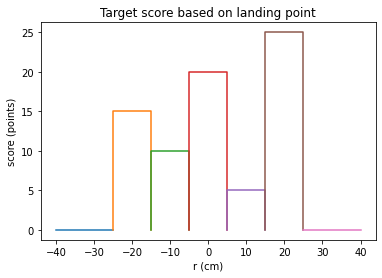

In [2]:
bands = [-np.inf,-25,-15,-5,5,15,25,np.inf]
scores = [0,15,10,20,5,25,0]

# Plot target score

s = np.linspace(-30,30,200)
for index, band in enumerate(scores):
    a = np.maximum(bands[index], -40)
    b = np.minimum(bands[index+1], 40)
    plt.plot((a,a,b,b),np.array((0,scores[index],scores[index],0)))

plt.xlabel('r (cm)')
plt.ylabel('score (points)')
plt.title('Target score based on landing point')
plt.show()

## Part A

In [3]:
def expected_utility(a, lapse_rate, sigma_motor, sigma_lapse=20, scores=scores):
    """Expected loss."""
    eutil = 0.
    for i in range(1, 6):
        eutil += ((1-lapse_rate)*sps.norm.cdf(bands[i+1], a, sigma_motor) + lapse_rate*sps.norm.cdf(bands[i+1], a, sigma_lapse) \
              - (1-lapse_rate)*sps.norm.cdf(bands[i], a, sigma_motor) - lapse_rate*sps.norm.cdf(bands[i], a, sigma_lapse))*scores[i]
    return eutil

def optimal_action(lapse_rate, sigma_motor):
    """Optimal action computation."""
    Na = 2**10+1
    a = np.linspace(-30., 30., Na).reshape((Na, 1))
    eutil = expected_utility(a, lapse_rate, sigma_motor)
    a_star = a[np.argmax(eutil.T, axis=1)]
    return a_star

N = 2**10+1
sigma_grid = np.linspace(2, 10, N).reshape((1, N))
lapse_grid = np.linspace(0, 0.2, N).reshape((1, N))

a_star = optimal_action(lapse_grid, sigma_grid)

print("leftmost:", np.min(a_star))
print("rightmost:", np.max(a_star))

leftmost: -1.7578125
rightmost: 19.921875


## Part B

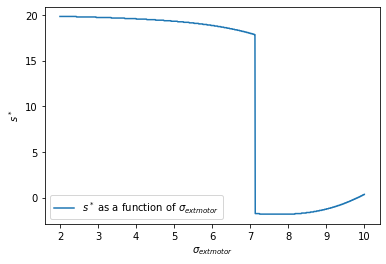

7.1328125


In [4]:
s_star = optimal_action(0.1, sigma_grid)

plt.plot( sigma_grid.flatten(), s_star.flatten(), label="$s^*$ as a function of $\sigma_{\text{motor}}$" )
plt.xlabel( "$\sigma_{\text{motor}}$" )
plt.ylabel( "$s^*$" )
plt.legend()
plt.show()

print(sigma_grid.flatten()[s_star.flatten() <= 0][0])

# Question 4.2 (6 pts)

> In this question, we will infer the empirical loss function of an observer in a task based on their responses.

In each trial of this experiment, the participant is shown a cloud of dots on a screen. The horizontal location of each dot is drawn from the following mixture distribution:
  $$
  p(s; h) = 0.8 \mathcal{N}\left(s; 0, 0.2^2\right) + 0.2 \mathcal{N}\left(s; h, 0.2^2\right)
  $$
  where $h$ is a parameter controlled by the experimenter, and is changed from trial to trial. The horizontal location is measured in normalized screen units $s \in [-1, 1]$, where $0$ is the center of the screen. 
- Along the vertical axis, the dots show a small jitter along the center of the screen (we ignore the vertical displacement).
- In each trial, the subject is asked to report the horizontal position of the *center* of the cloud of dots. The word "center" is ambiguous, as we could be asking for the mean, the median, or other [measures of central tendency](https://en.wikipedia.org/wiki/Central_tendency). The question is what the subject would naturally report. We assume the subject reports the estimate $\hat{s}$ that minimizes their expected loss. 
- For the purpose of this question, we also assume that the observer's loss function takes the parametric form
  $$
  \mathcal{L}_\alpha\left(s^\prime, s \right) = \left| s^\prime - s \right|^\alpha
  $$
  which is the loss for reporting $s^\prime$ for a dot position $s$. 
- In each trial, the expected loss is the expectation of the loss over the presented dot locations, $p(s; h)$.
- A sequence of trials is thus represented by the trial design (the presented distribution of dots, parameterized by $h_t$) and the observer's responses $\hat{s}_t$ in each trial $t$.
- For simplicity, here we assume that there is no response noise.

Given the data reported below, infer the exponent $\alpha \ge 0$ of the loss function that best describes the subject behavior. Do so by finding the $\alpha$ that minimizes the squared error between the model prediction (assuming the observer follows Bayesian decision theory) and the data. Report the best estimate for $\alpha$ in Moodle (error tolerance $\pm 0.1$).

*Notes*: 
- Assume that the horizontal location $s \in [-1, 1]$ (i.e., within the width of the screen).
- In real data, the observer's responses would be corrupted by decision and motor noise, which would make inferring the loss function still more complex. For example, it would be better to use Bayesian inference to infer a posterior over $\alpha$, as opposed to a point estimate. Still, the logic would be the same.

In [5]:
# Trial parameters h_t and subject's responses s_hat_t

h_t = np.array([-0.0663824 ,  0.17625959, -0.3999085 , -0.15813394, -0.28259529,
       -0.32612912, -0.25099183, -0.12355142, -0.08258602,  0.03105339,
       -0.06464439,  0.1481756 , -0.2364382 ,  0.30249395, -0.37808993,
        0.13637401, -0.06615616,  0.04695186, -0.28769045, -0.24151881])
s_hat_t = np.array([-0.0125   ,  0.034375 , -0.0734375, -0.03125  , -0.0546875,
       -0.0609375, -0.0484375, -0.025    , -0.0171875,  0.00625  ,
       -0.0125   ,  0.0296875, -0.0453125,  0.0578125, -0.0703125,
        0.0265625, -0.0125   ,  0.009375 , -0.0546875, -0.046875 ])

array([0.16601562])

# Question 4.3 (18 pts)

> For this question, which amounts to a small modelling and model fitting project, we will put together several topics seen in the course. Using the data of the sensorimotor timing experiment \[**AWV12**\] that we encountered several times in this course, we will use a Bayesian observer model to recover the observer's prior from their responses.

We analyze the data with the `gaussianmixobserverwithlapse` model, defines as follows:

- We assume the observer builds a (mismatched) Gaussian prior with two components:
  $$p(s) = w_\text{prior} \mathcal{N}\left(s| \mu_{\text{prior}}, \sigma_{\text{prior}, 1}^2 \right) + 
  \left(1 - w_\text{prior} \right)\mathcal{N}\left(s| \mu_{\text{prior}}, \sigma_{\text{prior}, 2}^2 \right)$$ 
  over the stimuli (time intervals). We assume the two components have the same mean $\mu_\text{prior}$, but different weights ($w_\text{prior}$ and $1 - w_\text{prior}$) and standard deviations ($\sigma_{\text{prior}, 1}$ and $\sigma_{\text{prior}, 2}$).
- We assume that the measurement distribution and likelihood are also Gaussian, $p(x|s) = \mathcal{N}\left(x| s, \sigma^2 \right)$.
- The observer uses the *posterior mean* estimator for the value of the stimulus, $\hat{s}_\text{PM}$.
- Gaussian motor response noise is added to the estimate, $p(r|\hat{s}) = \mathcal{N}\left(r| \hat{s}, \sigma_\text{motor}^2 \right)$. For this exercise, we assume that $\sigma_\text{motor} = 70$ ms for all subjects.
- In each trial, the observer lapses with probability $\lambda$ (the *lapse rate*), in which case the response is drawn from $p_\text{lapse}(r) = \text{Uniform}\left(r; 0, 1500 \right)$ ms. Otherwise, the observer responds normally (according to $p(r|\hat{s})$ described above) with probability $1 - \lambda$. 
- The free parameters of this model are $\mathbf{\theta} = \left(\sigma, \lambda, w_\text{prior}, \mu_\text{prior}, \sigma_{\text{prior}, 1}, \sigma_{\text{prior}, 2} \right)$.

Note that the parameters $w_\text{prior}, \mu_\text{prior}, \sigma_{\text{prior}, 1}, \sigma_{\text{prior,2}}$ model the subject's prior. In other words, we can use the estimates of these parameters to visualize what the subject's prior might look like.

-----------------------------------------------

For this analysis, we will separately consider all subjects, but for all subjects' datasets we will discard the first session, to ensure that subjects have achieved enough training in the task. We provide below example code that retrieves the stimuli $\mathbf{s}$ and responses $\mathbf{r}$ for a subject, withouth the first session.

- a) As a sanity check, compute the log-likelihood of model parameter $\theta_\star = \left(\sigma = 100, \lambda = 0.01, w_\text{prior} = 0.5, \mu_\text{prior} = 787, \sigma_{\text{prior}, 1} = 100, \sigma_{\text{prior}, 2} = 120 \right)$ for the dataset of subject 5 (having removed the first session) and report the result in Moodle.
- b) Separately fit the `gaussianmixobserverwithlapse` model to all the six subjects' datasets (removing the first session from all data) via maximum-likelihood estimation. For each subject, report the maximum log-likelihood value in Moodle.
- c) Consider now the `idealgaussianobserverwithlapse` observer model. The `idealgaussianobserverwithlapse` is the same as the model above with the difference that the observer's prior is a single Gaussian $p(s) = \mathcal{N}\left(s | \mu_\text{prior}, \sigma^2_\text{prior} \right)$ with $\mu_\text{prior} = 787.5$ ms and $\sigma_{\text{prior}} = 128.1$ ms. As above, we fix $\sigma_\text{motor} = 70$ ms. The `idealgaussianobserverwithlapse`  model has two free parameters, $\theta = \left(\sigma, \lambda \right)$. As a sanity check, compute the log-likelihood of model parameter $\theta_\star = \left(\sigma = 100, \lambda = 0.01\right)$ for the dataset of subject 5 (having removed the first session) and report the result in Moodle.
- d) Separately fit the `idealgaussianobserverwithlapse` model to all the six subjects' datasets (removing the first session from all data) via maximum-likelihood estimation.  For each dataset, separately compute the AIC and BIC for the two models `gaussianmixobserverwithlapse` and `idealgaussianobserverwithlapse`. Sum the AIC and BIC values across subjects to find the sum AIC (or BIC) of the two models. Report the summed AIC (and BIC) for the two models separately in Moodle.
- e) Which model is best, according to the metrics, and why do you think it is the case? Discuss your findings (max 300 words).

*Hints*:
- Both in parts (a) and (c), the log-likelihoods that you find should be between $-6000$ and $-5800$.
- There is an analytical solution for the posterior (and $\hat{s}_\text{PM}$), but there is no analytical solution for the response distribution $p(r|s)$, so you will need to use numerical integration at least to compute the response distribution.
- Finding the maximum-likelihood solution can be difficult as the optimization landscape is nontrivial. As a sanity check, verify that your solutions are consistent across different runs. If not, you might need to run additional optimization runs to increase the chance of finding the global optimum - possibly of the order of ten or even more.
- Beware that running multiple optimizations for all subjects will take quite some time (easily 30-60 minutes overall, possibly more - depending on your code, your computer, and how many runs you do). Model fitting is time consuming!
- Remember that you can ask questions in the Moodle discussion forum if you need further hints.

In [10]:
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt

# Load data of Experiment 3 of [AWV12] from .csv file to a Pandas dataframe
df = pd.read_csv('https://raw.githubusercontent.com/lacerbi/prob-cog-mod-files/main/data/awv12_exp3.csv')

# Remove unused columns
df.drop(df.columns[[6, 7, 8]], axis=1, inplace=True)

# Remove rows with NaNs
df.dropna(axis=0, inplace=True)

# Example code to take the data of subject 1, excluding the first session
subject = 1
s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])

sigma_motor = 70

## Part A

In [11]:
# Theta is [lambda, sigma, w_prior, mu_prior, sigma_prior_1, sigma_prior_2]
theta_star = np.array([0.01, 100, 0.5, 787, 100, 120])

def compute_posterior_mean(s_grid, prior_pdf, likelihood):
    """Compute s_hat_PM (posterior mean) for an arbitrary prior and likelihood in 1d."""
    ds = s_grid.flatten()[1] - s_grid.flatten()[0] # grid spacing
    protoposterior = prior_pdf * likelihood
    normalization_constant = sp.integrate.romb(protoposterior, dx=ds, axis=0)
    posterior_pdf = protoposterior / normalization_constant
    posterior_mean = sp.integrate.romb(s_grid * posterior_pdf, dx=ds, axis=0)
    return posterior_mean

def compute_response_numeric(theta, s_experiment, Nx=2**8+1, Ns=2**8+1, Nr=2**8+1):
    _, sigma, w_prior, mu_prior, sigma_prior_1, sigma_prior_2 = theta
    
    lb = mu_prior - (sigma_prior_1 + sigma_prior_2)*5
    ub = mu_prior + (sigma_prior_1 + sigma_prior_2)*5
    x_row = np.linspace(lb, ub, Nx).reshape((1, Nx)) # make x a row vector
    dx = x_row.flatten()[1] - x_row.flatten()[0]
    s_hyp_col = np.linspace(lb, ub, Ns).reshape((Ns, 1))
    
    prior = w_prior*sps.norm.pdf(s_hyp_col, mu_prior, sigma_prior_1) + (1-w_prior)*sps.norm.pdf(s_hyp_col, mu_prior, sigma_prior_2)
    likelihood = sps.norm.pdf(x_row, s_hyp_col, sigma)
    s_hat_row = compute_posterior_mean(s_hyp_col, prior, likelihood)
    
    r_grid = np.linspace(lb, ub, Nr).reshape((Nr, 1))
    motor_noise = sps.norm.pdf(r_grid, s_hat_row, sigma_motor)
    
    s_experiment = s_experiment.reshape((s_experiment.size, 1))
    measure_distribution = sps.norm.pdf(x_row, s_experiment, sigma)
    measure_distribution = np.expand_dims(measure_distribution, 0)
    motor_noise = np.expand_dims(motor_noise, 1)
    p_response = sp.integrate.romb(motor_noise*measure_distribution, dx=dx, axis=2)
    
    mu_resp = sp.integrate.romb(x_row.T*p_response, dx=dx, axis=0)
    std_resp = np.sqrt(sp.integrate.romb((x_row.T - mu_resp)**2 * p_response, dx=dx, axis=0))
    return mu_resp, std_resp

def gauss_mix_lapse_log_likelihood_numeric(theta, s_subject, r_subject):
    # Unpack theta
    lapse_rate, sigma, w_prior, mu_prior, sigma_prior_1, sigma_prior_2 = theta
    
    # log-pdf for the chance of a lapse
    lapse_pdf = sps.uniform.logpdf(r_subject, 1e-10, 1500) + np.log(lapse_rate)
    
    mu_resp, sigma_resp = compute_response_numeric(theta, s_subject)
    
    # log-pdf of a normal response
    loglike_vec = np.log(1-lapse_rate) + sps.norm.logpdf(r_subject,mu_resp,sigma_resp)
    
    # Setting up the terms for a log-sum-exp
    terms = [loglike_vec, lapse_pdf]
    lse_result = sp.special.logsumexp(terms, axis=0)
    
    return np.sum(lse_result)

s = np.array(df['Stimulus (ms)'][(df['Subject id'] == 5) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == 5) & (df['Session id'] > 1)])

print("Log-likelihood for subject 5 with theta_star:", gauss_mix_lapse_log_likelihood_numeric(theta_star, s, r))

Log-likelihood for subject 5 with theta_star: -5971.365115020627


In [43]:
# Theta is [lambda, sigma, w_prior, mu_prior, sigma_prior_1, sigma_prior_2]
theta_star = np.array([0.01, 100, 0.5, 787, 100, 120])

def compute_response(theta, s_experiment, Nx=2**8+1, Nr=2**8+1):
    _, sigma, w_prior, mu_prior, sigma_prior_1, sigma_prior_2 = theta
    
    lb = mu_prior - (sigma_prior_1 + sigma_prior_2)*5
    ub = mu_prior + (sigma_prior_1 + sigma_prior_2)*5
    x_row = np.linspace(lb, ub, Nx).reshape((1,Nx)) # make x a row vector
    dx = x_row.flatten()[1] - x_row.flatten()[0]
    
    w_1 = (sigma_prior_1**2) / (sigma_prior_1**2 + sigma**2)
    w_2 = (sigma_prior_2**2) / (sigma_prior_2**2 + sigma**2)
    mu_post_1 = w_1*x_row + (1-w_1)*mu_prior
    mu_post_2 = w_2*x_row + (1-w_2)*mu_prior
    s_hat_row = w_prior*mu_post_1 + (1-w_prior)*mu_post_2
    # s_hat_row = compute_posterior_mean(x_row, theta)
    
    r_grid = np.linspace(lb, ub, Nr).reshape((Nr, 1))
    motor_noise = sps.norm.pdf(r_grid, s_hat_row, sigma_motor)
    
    s_experiment = s_experiment.reshape((s_experiment.size, 1))
    measure_distribution = sps.norm.pdf(x_row, s_experiment, sigma)
    measure_distribution = np.expand_dims(measure_distribution, 0)
    motor_noise = np.expand_dims(motor_noise, 1)
    p_response = sp.integrate.romb(motor_noise*measure_distribution, dx=dx, axis=2)
    
    mu_resp = sp.integrate.romb(x_row.T*p_response, dx=dx, axis=0)
    std_resp = np.sqrt(sp.integrate.romb((x_row.T - mu_resp)**2 * p_response, dx=dx, axis=0))
    return mu_resp, std_resp


def gauss_mix_lapse_log_likelihood(theta, s_subject, r_subject):
    # Unpack theta
    lapse_rate, sigma, w_prior, mu_prior, sigma_prior_1, sigma_prior_2 = theta
    
    # log-pdf for the chance of a lapse
    lapse_pdf = sps.uniform.logpdf(r_subject, 1e-10, 1500) + np.log(lapse_rate)
    
    mu_resp, sigma_resp = compute_response(theta, s_subject)
    
    # log-pdf of a normal response
    loglike_vec = np.log(1-lapse_rate) + sps.norm.logpdf(r_subject,mu_resp,sigma_resp)
    
    # Setting up the terms for a log-sum-exp
    terms = [loglike_vec, lapse_pdf]
    lse_result = sp.special.logsumexp(terms, axis=0)
    
    return np.sum(lse_result)

## Part B

In [48]:
def multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs=3):
    """Simple function for multi-start optimization."""
    # Run num_runs optimization runs from different starting points    
    num_params = lower_bounds.shape[0]
    theta_res = np.zeros((num_runs,num_params))
    nll_res = np.zeros(num_runs)    
    
    for index in range(num_runs):
        if index == 0:
            theta0 = 0.5*(plausible_lower_bounds + plausible_upper_bounds)
        else:
            theta0 = np.random.uniform(low=plausible_lower_bounds,high=plausible_upper_bounds)    
        bounds = sp.optimize.Bounds(lower_bounds,upper_bounds,True) # Set hard bounds
        res = sp.optimize.minimize(target_fun, theta0, method='L-BFGS-B', bounds=bounds)
        nll_res[index] = res.fun
        theta_res[index] = res.x
        print('Run {}: log-likelihood {}'.format(index, -res.fun))
        
    # Pick the best solution
    idx_best = np.argmin(nll_res)
    nll_best = nll_res[idx_best]
    theta_best = theta_res[idx_best]        
    return nll_best,theta_best

def calc_aic_and_bic(s, theta_best, nll):
    num_params = np.shape(theta_best)[0]
    num_trials = np.shape(s)[0]

    aic = 2*nll + 2*num_params
    bic = 2*nll + num_params*np.log(num_trials)

    return aic, bic

def optimize_subject(subject, num_runs=3):
    s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    target_fun = lambda theta_: -gauss_mix_lapse_log_likelihood(np.array(theta_),s,r)

    # Define hard parameter bounds
    # Theta is [lambda, sigma, w_prior, mu_prior, sigma_prior_1, sigma_prior_2]
    lower_bounds = np.array([1e-6, 1., 0.01, 0., 1., 1.])
    upper_bounds = np.array([0.1, 1500., 0.99, 1500., 1500., 1500.])

    # Define plausible range
    plausible_lower_bounds = np.array([0.01, np.mean(s)*0.05, 0.1, np.mean(s)*0.5, np.mean(s)*0.05, np.mean(s)*0.05])
    plausible_upper_bounds = np.array([0.05, np.mean(s)*0.2, 0.9, np.mean(s)*1.5, np.mean(s)*0.2, np.mean(s)*0.2])

    nll_best, theta_best = multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs)
    print('The maximum-likelihood solution (dataset S{}) is theta_ML = {} with log-likelihood: {}'.format(
        subject, theta_best, -nll_best))
    aic, bic = calc_aic_and_bic(s, theta_best, nll_best)
    return aic, bic

In [ ]:
num_runs = 3
aic = np.empty(6)
bic = np.empty(6)
for i in range(6):
    aic[i], bic[i] = optimize_subject(i+1, num_runs)
print("Total AIC for mixture model:", aic.sum())
print("Total BIC for mixture model:", bic.sum())

Run 0: log-likelihood -11537.032217964135
Run 1: log-likelihood -11519.917539437836
Run 2: log-likelihood -11519.917156069714
The maximum-likelihood solution (dataset S1) is theta_ML = [1.00000000e-06 3.69509896e+01 6.98978861e-01 7.92181203e+02
 3.12466217e+01 3.26378398e+02] with log-likelihood: -11519.917156069714
Run 0: log-likelihood -5538.421082439012
Run 1: log-likelihood -5567.656678578438
Run 2: log-likelihood -5573.724609103672
The maximum-likelihood solution (dataset S2) is theta_ML = [1.00000000e-06 1.11046374e+01 5.41144357e-01 7.48875690e+02
 2.13775942e+02 1.13001126e+01] with log-likelihood: -5538.421082439012
Run 0: log-likelihood -6131.016349491927
Run 1: log-likelihood -6210.118913442074
Run 2: log-likelihood -6130.986524461159
The maximum-likelihood solution (dataset S3) is theta_ML = [8.19653248e-03 1.15486016e+02 5.05698305e-01 7.64997405e+02
 6.24273118e+01 7.05682955e+02] with log-likelihood: -6130.986524461159
Run 0: log-likelihood -5995.755047763788
Run 1: log

In [51]:
num_runs = 15
retry_subjects = [1, 3, 4]
for i in retry_subjects:
    optimize_subject(i, num_runs)

Run 0: log-likelihood -11519.979228897428
Run 1: log-likelihood -11519.97827074855
Run 2: log-likelihood -11520.039319222233
Run 3: log-likelihood -11520.284273330533
Run 4: log-likelihood -11519.975766185642
Run 5: log-likelihood -11519.978248355128
Run 6: log-likelihood -11520.219274423196
Run 7: log-likelihood -11520.183464021004


/home/vyeoms/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2126: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Run 8: log-likelihood -12084.498728254272
Run 9: log-likelihood -11519.978387835497
Run 10: log-likelihood -11519.979599618138
Run 11: log-likelihood -11520.032133088196
Run 12: log-likelihood -11520.287895079382
Run 13: log-likelihood -11519.9865246755
Run 14: log-likelihood -11519.97829316288
The maximum-likelihood solution (dataset S1) is theta_ML = [1.00000000e-06 3.72629789e+01 8.02740133e-01 7.92118416e+02
 3.66949437e+01 2.58228186e+02] with log-likelihood: -11519.975766185642
Run 0: log-likelihood -6133.859748714673
Run 1: log-likelihood -6131.016376302321
Run 2: log-likelihood -6169.564417810813
Run 3: log-likelihood -6225.812774722974
Run 4: log-likelihood -6210.84417171778
Run 5: log-likelihood -6200.851629090923
Run 6: log-likelihood -6131.736624133195
Run 7: log-likelihood -6131.016376822619
Run 8: log-likelihood -6131.016376386975
Run 9: log-likelihood -6130.957168157953
Run 10: log-likelihood -6131.016388145893
Run 11: log-likelihood -6303.844528848798
Run 12: log-likeli

In [52]:
num_runs = 5
retry_subjects = [1, 3, 4]
for i in retry_subjects:
    optimize_subject(i, num_runs)

Run 0: log-likelihood -11519.979228897428
Run 1: log-likelihood -11519.978297039639
Run 2: log-likelihood -11519.978333721156
Run 3: log-likelihood -11522.577255064198
Run 4: log-likelihood -11652.517235141517
The maximum-likelihood solution (dataset S1) is theta_ML = [1.00000000e-06 3.72734012e+01 9.89999538e-01 7.92103831e+02
 4.42195581e+01 1.87010753e+02] with log-likelihood: -11519.978297039639
Run 0: log-likelihood -6133.859748714673
Run 1: log-likelihood -6131.01637567499
Run 2: log-likelihood -6131.016376754247
Run 3: log-likelihood -6130.958291686529
Run 4: log-likelihood -6266.411062372599
The maximum-likelihood solution (dataset S3) is theta_ML = [8.19605439e-03 1.15571574e+02 4.05285431e-02 7.65393127e+02
 1.14388744e+03 1.35277739e+02] with log-likelihood: -6130.958291686529
Run 0: log-likelihood -5993.841531876112
Run 1: log-likelihood -5992.0974020886615
Run 2: log-likelihood -5993.841520955174
Run 3: log-likelihood -5993.841411012083
Run 4: log-likelihood -5994.73884997

In [53]:
num_runs = 5
retry_subjects = [1, 3]
for i in retry_subjects:
    optimize_subject(i, num_runs)

Run 0: log-likelihood -11519.979228897428
Run 1: log-likelihood -11520.02151165017
Run 2: log-likelihood -11519.978457698468
Run 3: log-likelihood -11519.978297334415
Run 4: log-likelihood -11520.043423515357
The maximum-likelihood solution (dataset S1) is theta_ML = [1.00000000e-06 3.72697445e+01 9.90000000e-01 7.92107022e+02
 4.42387123e+01 1.45884256e+02] with log-likelihood: -11519.978297334415
Run 0: log-likelihood -6133.859748714673
Run 1: log-likelihood -6131.016377734387
Run 2: log-likelihood -6131.016702165007
Run 3: log-likelihood -6131.01638318559
Run 4: log-likelihood -6130.957458090169
The maximum-likelihood solution (dataset S3) is theta_ML = [8.20145391e-03 1.15539721e+02 3.50416072e-01 7.65360663e+02
 1.20113775e+03 9.06668325e+01] with log-likelihood: -6130.957458090169


## Part C

In [7]:
theta_star = np.array([100, 0.01])

def gaussian_response(s,theta):
    """Compute mean and standard deviation of p(r|s; theta)."""
    # Unpack parameter vector theta
    mu_prior = 787.5
    sigma_prior = 128.1
    sigma_motor = 70
    sigma = theta[0]
    # Compute mean and std of the response
    w = sigma_prior**2/(sigma_prior**2 + sigma**2)    
    mu_resp = w*s + (1-w)*mu_prior
    sigma_resp = np.sqrt(w**2*sigma**2 + sigma_motor**2)
    return mu_resp, sigma_resp

def idealgaussianobserverwithlapse_loglike(theta, s_vec, r_vec):
    """Log-likelihood of ideal Gaussian observer with added lapse."""
    mu_prior = 787.5
    sigma_prior = 128.1
    sigma_motor = 70
    
    sigma = theta[0]
    lapse_rate = theta[1]
    
    # log-pdf for the chance of a lapse
    lapse_pdf = sps.uniform.logpdf(r_vec, 0, 1500) + np.log(lapse_rate)
    mu_resp, sigma_resp = gaussian_response(s_vec,theta)
    
    # log-pdf of a normal response
    loglike_vec = np.log(1-lapse_rate) + sps.norm.logpdf(r_vec,mu_resp,sigma_resp) # Vector of log-likelihood per trials
    
    # Setting up the terms for a log-sum-exp
    terms = [loglike_vec, lapse_pdf]
    lse_result = sp.special.logsumexp(terms, axis=0)
    
    return np.sum(lse_result)

s = np.array(df['Stimulus (ms)'][(df['Subject id'] == 5) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == 5) & (df['Session id'] > 1)])
print(idealgaussianobserverwithlapse_loglike(theta_star, s, r))

-5950.256415040454


## Part D

In [8]:
def multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs=3):
    """Simple function for multi-start optimization."""
    # Run num_runs optimization runs from different starting points    
    num_params = lower_bounds.shape[0]
    theta_res = np.zeros((num_runs,num_params))
    nll_res = np.zeros(num_runs)    
    
    for index in range(num_runs):
        if index == 0:
            theta0 = 0.5*(plausible_lower_bounds + plausible_upper_bounds)
        else:
            theta0 = np.random.uniform(low=plausible_lower_bounds,high=plausible_upper_bounds)    
        bounds = sp.optimize.Bounds(lower_bounds,upper_bounds,True) # Set hard bounds
        res = sp.optimize.minimize(target_fun, theta0, method='L-BFGS-B', bounds=bounds)
        nll_res[index] = res.fun
        theta_res[index] = res.x
        print('Run {}: log-likelihood {}'.format(index, -res.fun))
        
    # Pick the best solution
    idx_best = np.argmin(nll_res)
    nll_best = nll_res[idx_best]
    theta_best = theta_res[idx_best]        
    return nll_best,theta_best

def calc_aic_and_bic(s, theta_best, nll):
    num_params = np.shape(theta_best)[0]
    num_trials = np.shape(s)[0]

    aic = 2*nll + 2*num_params
    bic = 2*nll + num_params*np.log(num_trials)

    return aic, bic

def optimize_subject(subject, num_runs=3):
    s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    target_fun = lambda theta_: -idealgaussianobserverwithlapse_loglike(np.array(theta_),s,r)

    # Define hard parameter bounds
    lower_bounds = np.array([1., 1e-10])
    upper_bounds = np.array([1000., 1-1e-10])

    # Define plausible range
    plausible_lower_bounds = np.array([np.mean(s)*0.05, 0.01])
    plausible_upper_bounds = np.array([np.mean(s)*0.20, 0.05])

    print("Optimization loop...")
    nll_best, theta_best = multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs)
    print('The maximum-likelihood solution (dataset S{}) is theta_ML = {} with log-likelihood: {}'.format(
        subject, theta_best, -nll_best))
    aic, bic = calc_aic_and_bic(s, theta_best, nll_best)
    return aic, bic

num_runs = 3
aic = np.empty(6)
bic = np.empty(6)
for i in range(6):
    aic[i], bic[i] = optimize_subject(i+1, num_runs)
print("Total AIC for ideal gaussian with lapse model:", aic.sum())
print("Total BIC for ideal gaussian with lapse model:", bic.sum())


Optimization loop...
Run 0: log-likelihood -11624.338670310026
Run 1: log-likelihood -11624.338670297893
Run 2: log-likelihood -11624.338670298694
The maximum-likelihood solution (dataset S1) is theta_ML = [9.58173647e+01 1.00000000e-10] with log-likelihood: -11624.338670297893
Optimization loop...
Run 0: log-likelihood -5636.6277281441135
Run 1: log-likelihood -5636.62772814477
Run 2: log-likelihood -5636.627728174724
The maximum-likelihood solution (dataset S2) is theta_ML = [3.96772793e+01 1.00000000e-10] with log-likelihood: -5636.6277281441135
Optimization loop...
Run 0: log-likelihood -6137.263690600243
Run 1: log-likelihood -6137.26369010446
Run 2: log-likelihood -6137.263690088744
The maximum-likelihood solution (dataset S3) is theta_ML = [1.07498832e+02 9.81784133e-03] with log-likelihood: -6137.263690088744
Optimization loop...
Run 0: log-likelihood -6103.817274256799
Run 1: log-likelihood -6103.817274126373
Run 2: log-likelihood -6103.817274193609
The maximum-likelihood solu